# Reinforcement Learning
Prof. S. Harmeling, SS 2024

### Exercise sheet #7

#### 1. Implement Sarsa, Q-learning, and expected Sarsa.

In this notebook we will implement the three TD control algorithms Sarsa, Q-learning and expected Sarsa.  
The main difference between them is the TD target, e.g. for Sarsa:

$\begin{equation}
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha (\,\underbrace{r_{t+1} + \gamma Q(s_{t+1}, a_{t+1})}_{\text{TD target}} - Q(s_t, a_t))
\end{equation}$

The update rules of Q-learning and expected Sarsa can be found in the slides.  
Another difference is whether the next action is already selected before the update (only Sarsa).

#### Implementation

Make sure that the files `rl_agent.py` and `rl_env.py` are in the same folder as the notebook.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import rl_agent
import rl_env

#### Agents

The class `TDAgent` is a base class and uses the method `compute_target()` to compute the TD target.  
The three TD agents are subclasses of `TDAgent` and only need to implement this method.  
Follow the instructions in the code cells below.

In [16]:
class TDAgent(rl_agent.TabularAgent):

    def __init__(self, env, gamma, epsilon, alpha, rng=None):
        super().__init__(env)
        self.gamma = gamma      # discount factor
        self.epsilon = epsilon  # epsilon-greedy probability
        self.alpha = alpha      # learning rate
        self.rng = rng if rng is not None else np.random.default_rng()
        self.reset()

    def reset(self):
        # Create array for action values
        self.q = np.zeros((self.num_states, self.num_actions), dtype=float)
        # Create array for policy distribution (initialized uniformly)
        self.pi = np.full((self.num_states, self.num_actions), 1 / self.num_actions)

    def policy(self, state):
        # Sample an action according to pi
        action_probs = self.pi[state]
        action = self.rng.choice(self.num_actions, p=action_probs)
        return action

    def value(self, state):
        # Compute the state value from q and pi
        return np.sum(self.pi[state] * self.q[state])

    def action_value(self, state, action):
        # Lookup the action value in q
        return self.q[state, action]

    def policy_evaluation(self, state, action, reward, next_state, terminated, truncated):
        #######################################################################
        # TODO Perform one step of policy evaluation using compute_target().  #
        # Update the action value for the given transition. Remember to check #
        # if the episode is terminated. Note that Sarsa already selects the   #
        # next action, so in this case the method should return the next      #
        # action, in order to perform it in the environment.                  #
        #######################################################################
        
        if terminated:
            target = reward
            next_action = None
        else:
            target, next_action = self.compute_target(reward, next_state)

        q = self.q
        q[state, action] += self.alpha * (target - q[state, action])
        return next_action
        #######################################################################
        # End of your code.                                                   #
        #######################################################################

    def compute_target(self, reward, next_state):
        # Compute the TD target and the next action, if necessary.
        # Needs to be implemented in a subclass.
        raise NotImplementedError()

    def policy_improvement(self):
        # Update the policy using epsilon-greedy policy improvement
        q = self.q
        epsilon = self.epsilon

        # Find the maximizing actions
        max_q = np.max(q, axis=1, keepdims=True)
        max_mask = q == max_q
        num_max = np.sum(max_mask, axis=1, keepdims=True)

        # Compute the probabilities
        num_actions = q.shape[1]
        pi = ((1 - epsilon) / num_max) * max_mask
        pi += epsilon / num_actions
        self.pi = pi

In [17]:
class SarsaAgent(TDAgent):

    def compute_target(self, reward, next_state):
        #######################################################################
        # TODO Calculate the Sarsa target. Remember that this algorithm       #
        # already selects the next action, so it should be returned as well.  #
        #######################################################################
        next_action=self.policy(next_state)
        target=reward+self.gamma*self.q[next_state,next_action]
        
        return target, next_action
        #######################################################################
        # End of your code.                                                   #
        #######################################################################

In [18]:
class QLearningAgent(TDAgent):

    def compute_target(self, reward, next_state):
        #######################################################################
        # TODO Calculate the Q-learning target.                               #
        #######################################################################
        next_action=None
        target=reward+self.gamma*np.max(self.q[next_state])
        
        return target, next_action
        #######################################################################
        # End of your code.                                                   #
        #######################################################################

In [19]:
class ExpectedSarsaAgent(TDAgent):

    def compute_target(self, reward, next_state):
        #######################################################################
        # TODO Calculate the expected Sarsa target.                           #
        #######################################################################
        next_action=None
        target=reward+self.gamma*np.sum(self.q[next_state]*self.pi[next_state])
        
        return target, next_action
        #######################################################################
        # End of your code.                                                   #
        #######################################################################

#### Evaluation

Now we evaluate the three TD agents on the cliff walking environment.  
The goal is to recreate Figure 6.3 from the textbook http://incompleteideas.net/book/the-book-2nd.html  
which compares different learning rates $\alpha$.

First implement `train_td_agent()`, which learns a policy.

In [20]:
def train_td_agent(env, agent, num_episodes):
    #######################################################################
    # TODO Train a given TD agent by collecting `num_episodes` episodes   #
    # in the given environment and performing policy evaluation and       #
    # policy improvement.                                                 #
    #######################################################################
    for _ in range(num_episodes):
        state, _ = env.reset()
        terminated = False
        truncated = False
        action = None
        while not (terminated or truncated):
            if action is None:
                action = agent.policy(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            action = agent.policy_evaluation(state, action, reward, next_state, terminated, truncated)
            agent.policy_improvement()
            state = next_state
    #######################################################################
    # End of your code.                                                   #
    #######################################################################

Now implement `evaluate_td_agent()`, which evaluates a learned policy.

In [21]:
def evaluate_td_agent(env, agent, num_episodes):
    #######################################################################
    # TODO Evaluate a trained TD agent by collecting `num_episodes`       #
    # episodes and calculating the average sum of rewards per episode.    #
    #######################################################################
    sum_of_rewards = 0
    for _ in range(num_episodes):
        state, _ = env.reset()
        while True:
            action = agent.policy(state)
            state, reward, terminated, truncated, _ = env.step(action)
            sum_of_rewards += reward
            if terminated or truncated:
                break
    return sum_of_rewards / num_episodes
    #######################################################################
    # End of your code.                                                   #
    #######################################################################

Now we evaluate the three TD agents in the cliff walking environment.  
We want to compare their results when using different learning rates $\alpha \in \{0.1, 0.4, 0.7, 1.0\}$,  
so you need to train and evaluate each agent four times.  
Always use $\gamma = 1.0$ and $\epsilon = 0.1$, and train and evaluate for $3000$ episodes.

Evaluating alpha = 0.1
Evaluating alpha = 0.4
Evaluating alpha = 0.7
Evaluating alpha = 1.0


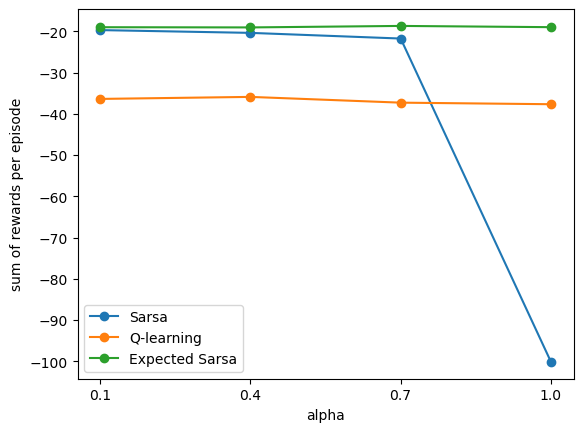

In [22]:
# Create a cliff walking environment
env = rl_env.cliff_walking()
gamma = 1.0    # discount factor
epsilon = 0.1  # epsilon-greedy probability
alphas = [0.1, 0.4, 0.7, 1.0]  # learning rates
num_train_episodes = 3000  # number of episodes for training
num_eval_episodes = 3000   # number of episodes for evaluation

#######################################################################
# TODO Train and evaluate the three agents as described above. Plot   #
# the resulting sums of rewards per episode, to recreate Figure 6.3   #
# from the textbook.                                                  #
#######################################################################
num_alphas = len(alphas)
sarsa_scores = np.zeros(num_alphas)
q_learning_scores = np.zeros(num_alphas)
expected_sarsa_scores = np.zeros(num_alphas)

for i, alpha in enumerate(alphas):
    print(f'Evaluating alpha = {alpha}')

    agent = SarsaAgent(env, gamma, epsilon, alpha)
    train_td_agent(env, agent, num_train_episodes)
    sarsa_scores[i] = evaluate_td_agent(env, agent, num_eval_episodes)

    agent = QLearningAgent(env, gamma, epsilon, alpha)
    train_td_agent(env, agent, num_train_episodes)
    q_learning_scores[i] = evaluate_td_agent(env, agent, num_eval_episodes)

    agent = ExpectedSarsaAgent(env, gamma, epsilon, alpha)
    train_td_agent(env, agent, num_train_episodes)
    expected_sarsa_scores[i] = evaluate_td_agent(env, agent, num_eval_episodes)

plt.xlabel('alpha')
plt.xticks(alphas)
plt.ylabel('sum of rewards per episode')
plt.plot(alphas, sarsa_scores, label='Sarsa', marker='o')
plt.plot(alphas, q_learning_scores, label='Q-learning', marker='o')
plt.plot(alphas, expected_sarsa_scores, label='Expected Sarsa', marker='o')
plt.legend();
#######################################################################
# End of your code.                                                   #
#######################################################################

What do you observe?